In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.misc import logsumexp

## Generate fake data

In [38]:
class FakeDataMaker(object):
    
    def __init__(self, thetas, weights):
        """ theta's are vectors of parameters for the mixture components. weights 
            are the mixture component weights. 
        """
        self.thetas = np.array(thetas)
        self.weights = np.array(weights) / np.sum(weights)
        self.K = len(self.weights)
        
        if len(self.thetas) != self.K:
            raise ValueError("Shape mismatch of thetas and weights")
    
    def generate(self, N, sigma_v=None):
        """ generate random draws from the 'true' model """
        
        comp_ixs = np.random.choice(self.K, p=self.weights, size=N)
        
        true_vs = np.zeros(N)
        for i in range(self.K):
            ix = comp_ixs == i
#             print("Mixture component {}:".format(i))
#             print("\t µ = {}".format(self.thetas[i,0]))
#             print("\t σ = {}".format(self.thetas[i,1]))
#             print("\t {} samples".format(sum(ix)))
             
            true_vs[ix] = np.random.normal(self.thetas[i,0], self.thetas[i,1], size=sum(ix))        
        
        # observe the velocities with known uncertainties
        if sigma_v is None:
            sigma_v = np.random.uniform(15.,20,size=N)
        v = np.random.normal(true_vs, sigma_v)
       
        return v, sigma_v

true_f_triand = 0.25
datamaker = FakeDataMaker(thetas=[[50.,20.], [0., 150.]],
                          weights=[true_f_triand, 1-true_f_triand])
vs,sigma_vs = datamaker.generate(N=100)

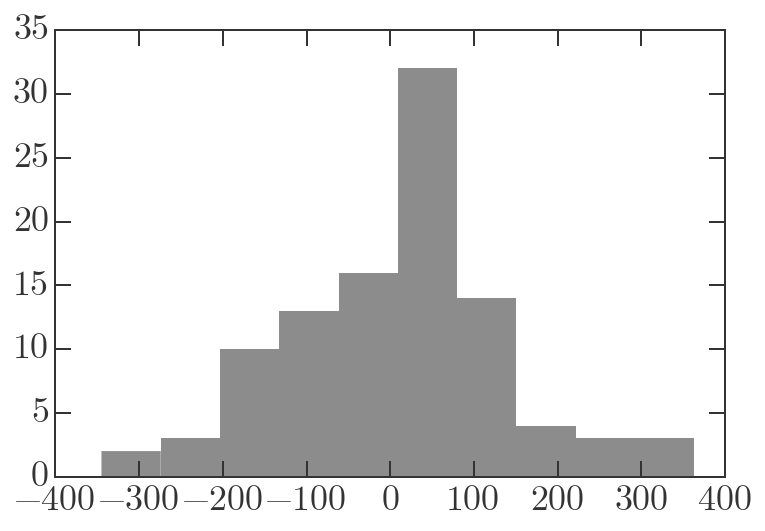

In [39]:
# plt.hist(vs, bins=int(3*np.std(vs)/len(vs)**(1/2.5)));
# n,bins,pa = plt.hist(true_vs, alpha=0.5, bins=int(3*np.std(vs)/len(vs)**(1/2.5)))
plt.hist(vs, alpha=0.5, bins=10);

In [54]:
def ln_likelihood(p, v, sigma_v, datamaker):
    f_triand = p[0]
    
    a = [f_triand, 1-f_triand]
    val = 0.
    for k in range(datamaker.K):
        mu_k = datamaker.thetas[k,0]
        sigma_k = datamaker.thetas[k,1]
        
        pref = a[k] / (2*np.pi*sigma_v*sigma_k)
        var_k = sigma_k**2
        var_n = sigma_v**2
        
        A = (var_k + var_n) / (2*var_n*var_k)
        B = (var_k*v + var_n*mu_k) / (var_n*var_k)
        C = -(var_k*v**2 + var_n*mu_k**2) / (2*var_n*var_k)
        
        val += pref * np.sqrt(np.pi/A) * np.exp(B**2 / (4*A) + C)
    
    ll = np.log(val).sum()
    return ll

def ln_prior(p):
    f_triand = p[0]
    if f_triand < 0 or f_triand > 1.:
        return -np.inf
    
    return 0.

def ln_prob(p, v, sigma_v, datamaker):
    lp = ln_prior(p)
    if np.isinf(lp):
        return -np.inf
    
    ll = ln_likelihood(p, v, sigma_v, datamaker).sum()
    return ll + lp

In [41]:
ln_likelihood([true_f_triand], vs, sigma_vs, datamaker), ln_likelihood([0.1], vs, sigma_vs, datamaker)

(-628.23605770846598, -628.62815374763341)

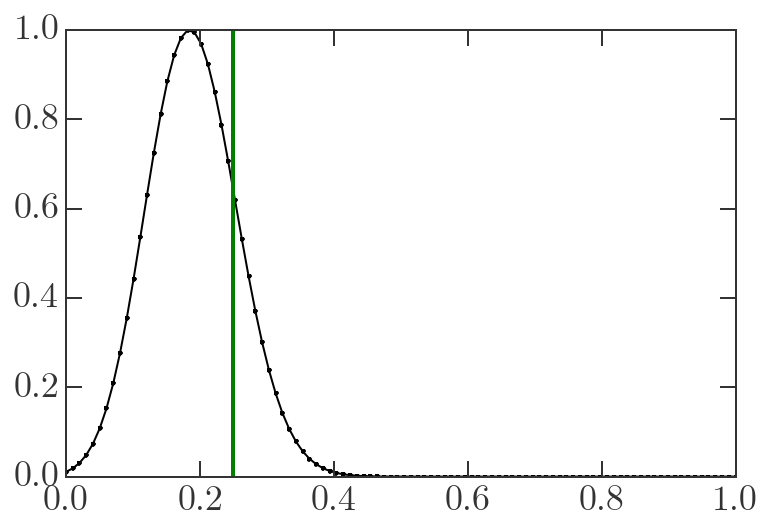

In [42]:
lls = []
fs = np.linspace(0., 1., 100)
for f in fs:
    lls.append(ln_likelihood([f], vs, sigma_vs, datamaker).sum())
lls = np.array(lls)

plt.plot(fs, np.exp(lls-lls.max()), color='k', alpha=1.)
plt.axvline(true_f_triand, color='g', linewidth=2.)

In [43]:
ntrials = 1024
all_lls = []

for i in range(ntrials):
    vs,sigma_vs = datamaker.generate(N=20)
    
    lls = []
    fs = np.linspace(0., 1., 100)
    for f in fs:
        lls.append(ln_likelihood([f], vs, sigma_vs, datamaker).sum())
    lls = np.array(lls)
    all_lls.append(lls)
all_lls = np.array(all_lls)

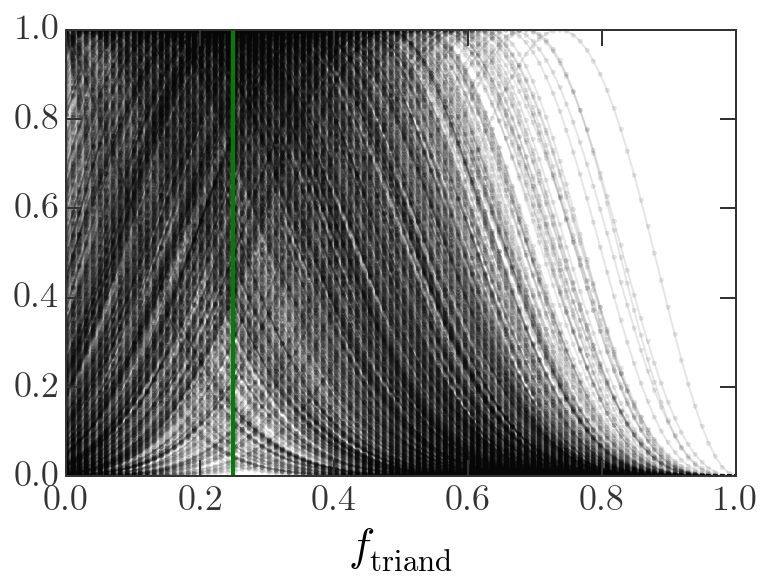

In [44]:
for i in range(ntrials):
    plt.plot(fs, np.exp(all_lls[i]-all_lls[i].max()), color='k', alpha=0.1)
    
plt.axvline(true_f_triand, color='g', linewidth=2.)
plt.xlabel(r"$f_{\rm triand}$")

In [52]:
import emcee

In [59]:
in_onesigma = []
for i in range(ntrials):    
    vs,sigma_vs = datamaker.generate(N=20)
    
    p0 = np.random.uniform(size=(32,1))
    sampler = emcee.EnsembleSampler(32, 1, ln_prob, args=(vs, sigma_vs, datamaker))
    pos,_,_ = sampler.run_mcmc(p0, 32)
    
#     for chain in sampler.chain:
#         plt.plot(np.arange(-len(chain),0), chain[:,0], marker=None, drawstyle='steps', alpha=0.1)
    
    sampler.reset()
    sampler.run_mcmc(pos, 256)
    
#     for chain in sampler.chain:
#         plt.plot(chain[:,0], marker=None, drawstyle='steps', alpha=0.1)

    mean_f = np.mean(sampler.flatchain[:,0])
    std_f = np.mean(sampler.flatchain[:,0])
    
    derp = (mean_f - std_f) < true_f_triand < (mean_f + std_f)
    print(derp)
    in_onesigma.append(derp)

True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
False
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


Traceback (most recent call last):
  File "/Users/adrian/anaconda/lib/python2.7/site-packages/emcee-2.1.0-py2.7.egg/emcee/ensemble.py", line 505, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-54-9644561432e1>", line 35, in ln_prob
    ll = ln_likelihood(p, v, sigma_v, datamaker).sum()
  File "<ipython-input-54-9644561432e1>", line 18, in ln_likelihood
    val += pref * np.sqrt(np.pi/A) * np.exp(B**2 / (4*A) + C)
KeyboardInterrupt
ERROR: KeyboardInterrupt [IPython.core.interactiveshell]
ERROR:astropy:KeyboardInterrupt



  params: [ 0.2585433]
  args: (array([  46.01530213,   48.67501726,  -39.71777941,   69.3871432 ,
        230.43630072,  -80.30823998,  -98.47101024,   17.14176491,
         34.93530691, -139.19542869,   13.89951642,  -54.49596078,
          8.51730986,  -54.21646018,  -49.99081807, -131.66938021,
         -1.72219226,  -57.88602701,   26.84909913,  145.37757344]), array([ 17.17977017,  19.80847464,  17.96960566,  16.96409662,
        15.36759055,  15.16299138,  16.88076365,  18.59843756,
        18.5875061 ,  16.69771105,  18.78306102,  17.86350484,
        19.79214614,  18.38212824,  17.30602528,  16.28742898,
        15.6170755 ,  16.90373214,  15.68604403,  18.22858605]), <__main__.FakeDataMaker object at 0x113f45910>)
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [61]:
in_onesigma = np.array(in_onesigma)

in_onesigma.sum() / float(len(in_onesigma))

0.94518272425249172

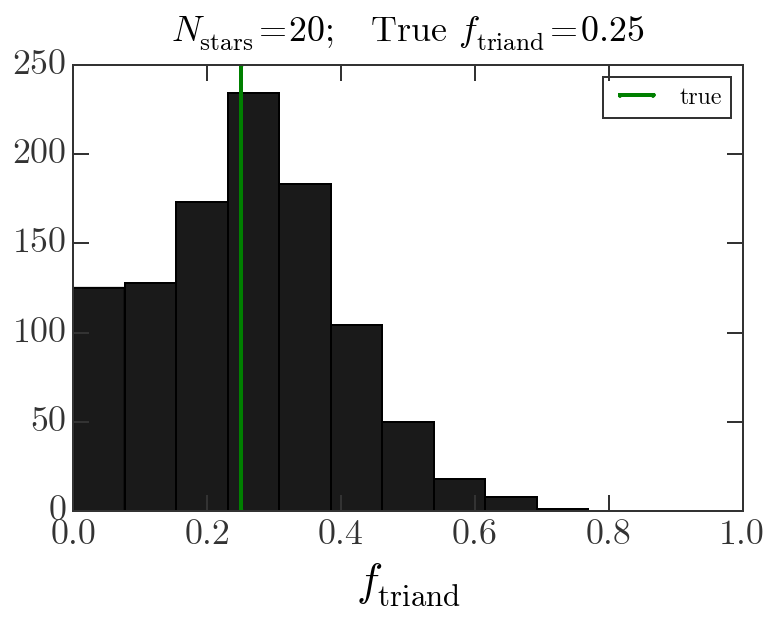

In [72]:
plt.hist(fs[all_lls.argmax(axis=1)], bins=np.linspace(0.,1.,14), edgecolor='k')
plt.axvline(true_f_triand, color='g', linewidth=2., label='true')
plt.title(r"$N_{{\rm stars}} = {}$;   True $f_{{\rm triand}} = {}$".format(len(vs), true_f_triand), 
          fontsize=18, y=1.03)
plt.xlabel(r"$f_{\rm triand}$")
plt.legend()